## Sparse Spectrogram of *Für Elise* Using Proximal Optimization

This notebook creates a sparse spectrogram of the classical music piece *Für Elise* using compressed sensing.
The main steps include:
- Audio normalization and chunking
- Fourier basis generation using piano key frequencies
- Sparse signal recovery using **Accelerated Proximal Gradient Descent (APGD)**
- Spectrogram visualization


In [151]:
import numpy as np
from scipy.io import wavfile

### Audio Preprocessing

- `rescale_audio`: Normalizes audio data to fit within [-1, 1] range
- `get_audio_chunks`: Splits the audio waveform into fixed-length segments (30ms)


In [152]:
def rescale_audio(data):
    if data.min() < -1 or data.max() > 1:
        data = data / max(abs(data.min()), abs(data.max()))

    return data

def get_audio_chunks(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]


### Gradient and Proximal Operators

- `grad_least_squares`: Gradient of the squared loss term \( \nabla_x \|Ax - y\|^2 \)
- `prox12norm`: Proximal operator for the 1-2 group norm (used for group sparsity)
- `apgd`: Implements Accelerated Proximal Gradient Descent for faster convergence on composite objectives


In [154]:
def grad_least_squares(A, x, y):
    return A.T @ (A @ x - y)

def prox12norm(x, gamma, d=2):
    x = x.reshape(-1, d)
    norm = np.linalg.norm(x, axis=1, keepdims=True)
    factor = np.maximum(1 - gamma / norm, 0)
    x = factor * x

    return x.reshape(-1)
def apgd(gradf, proxf, gamma, L, x, tol=1e-6, maxit=1e5):
    # x = x0
    z = x.copy()
    t = 1
    step_size = 1 / L
    for i in range(maxit):
        # grad step
        grad = gradf(z)
        x_next = proxf(z-step_size*grad, gamma*step_size)
        # momentum step
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        z_next = x_next + ((t - 1) / t_new) * (x_next - x)

        if np.linalg.norm(x_next-x) <= tol:
            # print(z)
            return x_next,i
        t = t_new
        x = x_next
        z = z_next


        
    # print(z)
    return x, maxit+1


- `get_piano_keys`: Returns fundamental frequencies for the 88 piano keys
- `get_A`: Builds a matrix where each column is a sine or cosine function at a piano frequency
  - This acts like a **Fourier basis tailored to piano notes**
- `apgd_driver`: Runs sparse recovery on each 30ms chunk using the APGD solver.
  - Reconstructs the activation of piano notes over time for each chunk.
- `generate_spectograms`: Plots a sparse piano roll-like spectrogram over time.
  - Strong activations (green) indicate likely note presence.
  - Weaker activations (yellow) are shown with reduced intensity.




In [155]:
def get_piano_keys():
    keys = [27.5 * (2 ** (i / 12)) for i in range(88)]
    return keys

def get_A(frequencies, f_s, l):
    A = np.zeros((l, 2*len(frequencies)))
    for i, f in enumerate(frequencies):
        for j in range(l):
            A[j, 2 * i] = np.cos(2 * np.pi * f * j / f_s)
            A[j, 2 * i + 1] = np.sin(2 * np.pi * f * j / f_s)
    return A



In [156]:
def apgd_driver(data, f_s, l, d = 2, gamma=4.0, tol=1e-6, maxit=10**5):

    f = get_piano_keys()
    A = get_A(f, f_s, l)
    L = np.linalg.norm(A.T @ A, ord=2)
    result = []
    x0 = np.zeros(A.shape[1])
    for i, y in enumerate(data[:-1]):
        x, iters = apgd(lambda x: grad_least_squares(A,x,y), lambda x, t: prox12norm(x, t, d), gamma, L, x0, tol, maxit)

        result.append(x)
    return result


In [ ]:
import matplotlib.pyplot as plt

def generate_spectograms(weights, frequencies):
    spectrograms = [np.sqrt(x[::2]**2 + x[1::2]**2) for x in weights]
    spectrograms = np.array(spectrograms)

    M = np.max(spectrograms)
    plt.figure(figsize=(10, 6))
    for i, x_bar in enumerate(spectrograms):
        for j, val in enumerate(x_bar):
            if val >= M / 8:
                plt.hlines(frequencies[j], i * 0.03, (i + 1) * 0.03, color='green')
            elif val > 0:
                plt.hlines(frequencies[j], i * 0.03, (i + 1) * 0.03, color='yellow')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Sparse Spectrogram of Für Elise")
    plt.show()

/opt/homebrew/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


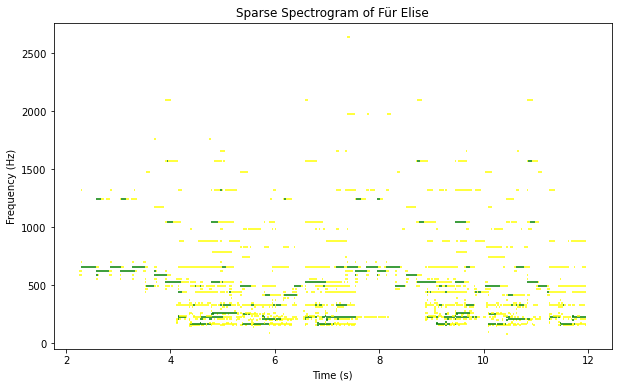

In [158]:
samplerate, data_orig = wavfile.read('furelise.wav')
data = data_orig / np.max(np.abs(data_orig))
l = round(0.03 * samplerate)
audio_chunks = list(get_audio_chunks(data, l))
num_blocks = len(data) // l

result = apgd_driver(audio_chunks, samplerate, l)
generate_spectograms(result, get_piano_keys())
